In [1]:
!pip install Iprogress

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTokenizer, CLIPTextModel, CLIPImageProcessor
import os
from PIL import Image
from tqdm import tqdm

from lcm_pipeline import LatentConsistencyModelPipeline
from lcm_scheduler import LCMScheduler

In [3]:
from IPython.display import display
import datetime
import numpy as np
import PIL

In [28]:
save_path = "./lcm_images"
os.makedirs(save_path, exist_ok=True)

In [29]:
torch.cuda.is_available()

True

In [31]:
model_id = "SimianLuo/LCM_Dreamshaper_v7"
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
scheduler = LCMScheduler(beta_start=0.00085, beta_end=0.0120, beta_schedule="scaled_linear", prediction_type="epsilon")

In [32]:
pipe = LatentConsistencyModelPipeline(vae=vae, text_encoder=text_encoder, tokenizer=tokenizer, unet=unet, scheduler=scheduler, safety_checker=None, feature_extractor=None)
pipe = pipe.to("cuda")

In [25]:
scheduler

LCMScheduler {
  "_class_name": "LCMScheduler",
  "_diffusers_version": "0.29.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [10]:
ddpm_scheduler = DDPMScheduler.from_pretrained(
     "runwayml/stable-diffusion-v1-5", subfolder="scheduler", revision=None
 )

In [11]:
ddpm_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.29.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [33]:
!nvidia-smi

Wed Oct 16 14:17:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   55C    P2             111W / 350W |   6457MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#prompt = "potrait of adorable 11-year-old skinny small British girls in pool sexy bikini pose.(straight hair:1.2), (small breast:1.9), full body, skinny, smirk, smooth, sharp focus, highly detailed, photo realism"
prompt = "smiling maitreya budai maltese dog, full body"
images = pipe(prompt=prompt, num_images_per_prompt=10, num_inference_steps=8, width=480, height=480, guidance_scale=6.0, lcm_origin_steps=50).images
# cond + w*(cond - uncond)
for i in range(len(images)):
    image = images[i]
    print(i)
    display(image)

  0%|          | 0/8 [00:00<?, ?it/s]

In [35]:
for i in range(len(images)):
    if i==8 and i==5:
        continue
    current_time = datetime.datetime.now().strftime("%H-%M-%S-%f")
    filename = f"{current_time}.png"
    output_path = os.path.join(save_path, filename)
    image = images[i]
    image.save(output_path)

In [274]:
!nvidia-smi

Mon Jul 22 11:49:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   50C    P8              23W / 350W |  21618MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [279]:
len(scheduler)

1000

In [283]:
num_train_timesteps = 1000
lcm_origin_steps = 50
num_inference_steps = 4

c = num_train_timesteps // lcm_origin_steps
# LCM Training  Steps Schedule
lcm_origin_timesteps = np.asarray(list(range(1, lcm_origin_steps + 1))) * c  - 1
print(lcm_origin_timesteps)

[ 19  39  59  79  99 119 139 159 179 199 219 239 259 279 299 319 339 359
 379 399 419 439 459 479 499 519 539 559 579 599 619 639 659 679 699 719
 739 759 779 799 819 839 859 879 899 919 939 959 979 999]


In [320]:
skipping_step = len(lcm_origin_timesteps) // num_inference_steps
print(len(lcm_origin_timesteps))
print(num_inference_steps)
print(skipping_step)
timesteps = lcm_origin_timesteps[::-skipping_step]
print(timesteps)

50
4
12
[999 759 519 279  39]


In [327]:
tl = [i for i in np.arange(100)]
print(tl[::-2])

[99, 97, 95, 93, 91, 89, 87, 85, 83, 81, 79, 77, 75, 73, 71, 69, 67, 65, 63, 61, 59, 57, 55, 53, 51, 49, 47, 45, 43, 41, 39, 37, 35, 33, 31, 29, 27, 25, 23, 21, 19, 17, 15, 13, 11, 9, 7, 5, 3, 1]


In [291]:
for i,t in enumerate(scheduler.timesteps):
    print("i=",i,", t=",t)

i= 0 , t= tensor(999)
i= 1 , t= tensor(759)
i= 2 , t= tensor(519)
i= 3 , t= tensor(279)


In [ ]:
# 7. LCM MultiStep Sampling Loop:
with self.progress_bar(total=num_inference_steps) as progress_bar:
    for i, t in enumerate(timesteps):

        ts = torch.full((bs,), t, device=device, dtype=torch.long)

        # model prediction (v-prediction, eps, x)
        model_pred = self.unet(
            latents,
            ts,
            timestep_cond=w_embedding,
            encoder_hidden_states=prompt_embeds,
            cross_attention_kwargs=cross_attention_kwargs, 
            return_dict=False)[0]

        # compute the previous noisy sample x_t -> x_t-1
        latents, denoised = self.scheduler.step(model_pred, i, t, latents, return_dict=False)

        # # call the callback, if provided
        # if i == len(timesteps) - 1:
        progress_bar.update()

In [ ]:
# 5. Sample z ~ N(0, I), For MultiStep Inference
# Noise is not used for one-step sampling.

if len(timesteps) > 1:
    noise = torch.randn(model_output.shape).to(model_output.device)
    prev_sample = alpha_prod_t_prev.sqrt() * denoised + beta_prod_t_prev.sqrt() * noise
else:
    prev_sample = denoised

In [292]:
def scalings_for_boundary_conditions(timestep, sigma_data=0.5, timestep_scaling=10.0):
    scaled_timestep = timestep_scaling * timestep
    c_skip = sigma_data**2 / (scaled_timestep**2 + sigma_data**2)
    c_out = scaled_timestep / (scaled_timestep**2 + sigma_data**2) ** 0.5
    return c_skip, c_out

In [301]:
print(scalings_for_boundary_conditions(0))
print(scalings_for_boundary_conditions(1))
print(scalings_for_boundary_conditions(999))

(1.0, 0.0)
(0.0024937655860349127, 0.9987523388778445)
(2.5050075037374525e-09, 0.9999999987474963)


In [20]:
from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.schedulers import SchedulerMixin

In [21]:
class SchedulerTest(SchedulerMixin, ConfigMixin):
    @register_to_config
    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.00085,
        beta_end: float = 0.012,
        beta_schedule: str = "scaled_linear",
        trained_betas= None,
        original_inference_steps: int = 50,
        clip_sample: bool = False,
        clip_sample_range: float = 1.0,
        set_alpha_to_one: bool = True,
        steps_offset: int = 0,
        prediction_type: str = "epsilon",
        thresholding: bool = False,
        dynamic_thresholding_ratio: float = 0.995,
        sample_max_value: float = 1.0,
        timestep_spacing: str = "leading",
        timestep_scaling: float = 10.0,
        rescale_betas_zero_snr: bool = False,
    ):
        if trained_betas is not None:
            self.betas = torch.tensor(trained_betas, dtype=torch.float32)
        elif beta_schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, dtype=torch.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=torch.float32) ** 2
        elif beta_schedule == "squaredcos_cap_v2":
            # Glide cosine schedule
            self.betas = betas_for_alpha_bar(num_train_timesteps)
        else:
            raise NotImplementedError(f"{beta_schedule} is not implemented for {self.__class__}")

        # Rescale for zero SNR
        if rescale_betas_zero_snr:
            self.betas = rescale_zero_terminal_snr(self.betas)

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # At every step in ddim, we are looking into the previous alphas_cumprod
        # For the final step, there is no previous alphas_cumprod because we are already at 0
        # `set_alpha_to_one` decides whether we set this parameter simply to one or
        # whether we use the final alpha of the "non-previous" one.
        self.final_alpha_cumprod = torch.tensor(1.0) if set_alpha_to_one else self.alphas_cumprod[0]

        # standard deviation of the initial noise distribution
        self.init_noise_sigma = 1.0

        # setable values
        self.num_inference_steps = None
        self.timesteps = torch.from_numpy(np.arange(0, num_train_timesteps)[::-1].copy().astype(np.int64))
        self.custom_timesteps = False

        self._step_index = None
        self._begin_index = None    

In [22]:
scheduler_test = SchedulerTest()

In [23]:
scheduler_test

SchedulerTest {
  "_class_name": "SchedulerTest",
  "_diffusers_version": "0.29.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "original_inference_steps": 50,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_scaling": 10.0,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [23]:
#data_root = '/home/bobo/LCMSenv/data/mnist_5x10_64'
data_root = '/nfs/work/dataset/mnist_5x10_64'
os.makedirs(data_root, exist_ok=True)


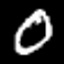

In [276]:
transforms.ToPILImage()(mnist.data[1]).resize((64,64))

In [4]:
import torchvision.datasets as datasets
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [7]:
classes_sortby_idx = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}

for i in range(len(mnist)):
    classes_sortby_idx[int(mnist.targets[i])].append(i)
    
for cls in range(len(mnist.classes)):
    print(f"len of label {cls} is {len(classes_sortby_idx[cls])}")
    

len of label 0 is 5923
len of label 1 is 6742
len of label 2 is 5958
len of label 3 is 6131
len of label 4 is 5842
len of label 5 is 5421
len of label 6 is 5918
len of label 7 is 6265
len of label 8 is 5851
len of label 9 is 5949
60000


In [47]:
to_PIL = transforms.ToPILImage()
zeros_channel = torch.zeros_like(mnist.data)

mnist_imgs = dict()
mnist_imgs['bw'] = mnist.data.unsqueeze(1).repeat(1,3,1,1)
mnist_imgs['red'] = torch.stack((mnist.data, zeros_channel, zeros_channel), dim=1)
mnist_imgs['grn'] = torch.stack((zeros_channel, mnist.data, zeros_channel), dim=1)
mnist_imgs['blu'] = torch.stack((zeros_channel, zeros_channel, mnist.data), dim=1)
mnist_imgs['ylw'] = torch.stack((mnist.data, mnist.data, zeros_channel), dim=1)

In [45]:
for cls in range(len(classes_sortby_idx)):
    # Directory paths for each image
    for k in mnist_imgs:
        os.makedirs(os.path.join(data_root, f'{k}_{cls}'), exist_ok=True)
                 
    for idx in classes_sortby_idx[cls]:
        colored_img = []
        for k in mnist_imgs:
            # 1 image for each bw, red, green, blue, yellow 
            colored_img.append(to_PIL(mnist_imgs[k][idx]).resize((64, 64)))

            for img in colored_img:
                img.save(os.path.join(data_root, f'{k}_{cls}', "{:05d}.jpg".format(idx)))

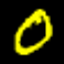

In [48]:
to_PIL(mnist_imgs['ylw'][1]).resize((64,64))

In [ ]:
train.py --arch unetic --data /root/notebooks/nfs/work/dataset/mnist_5x10_64 --lr 6e-5 --num_condition 5 10 --epochs 50 --exp Colored_Mnist_5x10 --dir ddim_IC